<a href="https://colab.research.google.com/github/Sudipta-Mitra/Stock-Price-Trend-Prediction-with-LSTM/blob/main/stock_price_for_126_days.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from datetime import timedelta

In [2]:
# Load scaler and model
scaler = joblib.load("/content/scaler.joblib")
model = load_model("/content/lstm_stock_model.h5")

In [4]:
# Load your latest stock data (ensure it's same format used in training)
df = pd.read_csv("/content/reliance_new..csv", parse_dates=["Date"])
df = df.sort_values("Date")

In [14]:
data = df.select_dtypes(include=np.number).values
scaled_data = scaler.transform(data) # Keep all 5 features scaled

# Extract the first feature for LSTM input
lstm_input_data = scaled_data[:, 0].reshape(-1, 1) # Reshape to (n_samples, 1)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [8]:
# Scale the data
scaled_data = scaler.transform(data)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [15]:
# Prepare the last N days as input (N = lookback window you trained on, e.g. 60)
lookback = 60  # change if your model used different value
# Use the 1-feature data for creating the last sequence
last_sequence = lstm_input_data[-lookback:]

In [16]:
# Predict next 6 months (~126 trading days)
future_predictions = []
# Reshape the initial sequence to (batch_size, lookback, num_features) where num_features is 1
current_sequence = last_sequence.reshape(1, lookback, 1)

for _ in range(126):  # ~6 months trading days
    pred = model.predict(current_sequence, verbose=0)
    # The model predicts a single value, so pred[0] is already a 1-element array
    future_predictions.append(pred[0])
    # update sequence by appending new prediction
    # Reshape the prediction to match the expected input shape of the LSTM (batch_size, 1, num_features)
    new_feature = pred[0].reshape(1, 1, 1)
    current_sequence = np.append(current_sequence[:, 1:, :], new_feature, axis=1)

In [17]:
last_known_features = scaled_data[-1, 1:] # Get the last known values for features 2 to 5

# Create an array with the predicted Close price and the last known values of other features
# This will be used for inverse transformation
predictions_for_inverse_transform = []
for pred_close in future_predictions:
    # Combine the predicted Close price with the last known values of other features
    combined_features = np.insert(last_known_features, 0, pred_close[0])
    predictions_for_inverse_transform.append(combined_features)

# Convert to numpy array
predictions_for_inverse_transform = np.array(predictions_for_inverse_transform)

# Inverse transform
future_predictions_original_scale = scaler.inverse_transform(predictions_for_inverse_transform)

In [18]:
# Build future dataframe
last_date = df["Date"].iloc[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 127)]
# The inverse transformed predictions now have 5 columns
future_df = pd.DataFrame(future_predictions_original_scale, columns=["Close", "Open", "High", "Low", "Volume"]) # Assuming the order of features is Close, Open, High, Low, Volume
future_df["Date"] = future_dates

# Display the future predictions
display(future_df.head())

,Close,Open,High,Low,Volume,Date
0,1205.535189,1214.250373,1201.351937,1203.194553,6405475.0,2025-01-01
1,1203.702989,1214.250373,1201.351937,1203.194553,6405475.0,2025-01-02
2,1201.606804,1214.250373,1201.351937,1203.194553,6405475.0,2025-01-03
3,1199.390070,1214.250373,1201.351937,1203.194553,6405475.0,2025-01-04
4,1197.114698,1214.250373,1201.351937,1203.194553,6405475.0,2025-01-05


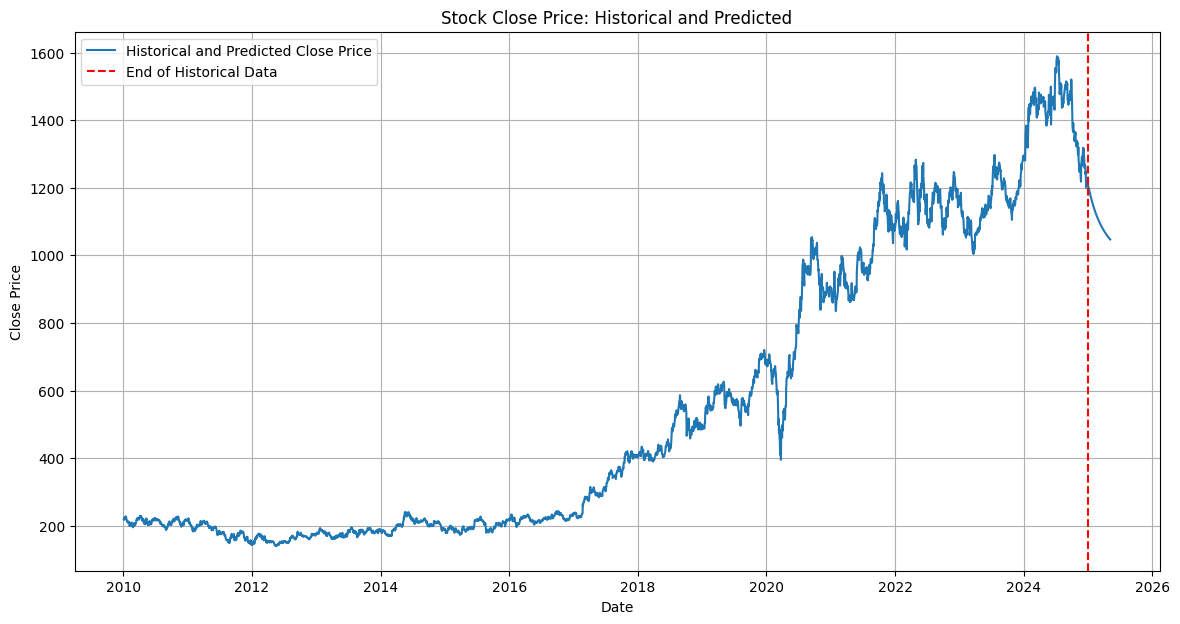

In [19]:
import matplotlib.pyplot as plt

# Combine historical and future data for plotting
# We only need the 'Date' and 'Close' columns
historical_close = df[['Date', 'Close']]
future_close = future_df[['Date', 'Close']]

# Concatenate the two dataframes
combined_close = pd.concat([historical_close, future_close], ignore_index=True)

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(combined_close['Date'], combined_close['Close'], label='Historical and Predicted Close Price')
plt.axvline(x=df['Date'].iloc[-1], color='red', linestyle='--', label='End of Historical Data') # Mark the separation point

plt.title('Stock Close Price: Historical and Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()